In [9]:
# import os
# import gdal
# import zipfile
# import numexpr
# import datetime
# import requests
# import warnings
# import odc.algo
# import numpy as np
# import pandas as pd
# import xarray as xr
# from collections import Counter
# from scipy.ndimage import binary_dilation

import sys
import datacube    

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import animated_timeseries
from dea_coastaltools import tidal_tag
from dea_dask import create_local_dask_cluster

dc = datacube.Datacube(app='Animated timeseries', env='c3-samples')

# Configure local dask cluster
create_local_dask_cluster()
   
import numpy as np
from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask

def hsv_image_processing(rgb_array,
                         hue_mult=1, sat_mult=1.035, val_mult=1.035,
                         unsharp_radius1=20, unsharp_amount1=2.5, 
                         unsharp_radius2=1, unsharp_amount2=1.0):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Apply unsharp mask and take average
    a = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius1, amount=unsharp_amount1)
    b = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius2, amount=unsharp_amount2)
    hsv_array[:, :, 2] = np.mean(np.array([a, b]), axis=0)
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))


# %load_ext autoreload
# %autoreload 2

Client Scheduler: tcp://127.0.0.1:38500 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


In [28]:
from odc.ui import select_on_a_map
    
# Plot interactive map to select area
geopolygon = select_on_a_map(height='600px', 
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [29]:
# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1988', '2018'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'average'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000}
}

ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              min_gooddata=0.80,
              ls7_slc_off=False,
              mask_contiguity=False,
              mask_pixel_quality=False,
              **query)



../../Scripts/dea_datahandling.py:227: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 307 out of 511 time steps with at least 80.0% good quality pixels
Returning 307 time steps as a dask array


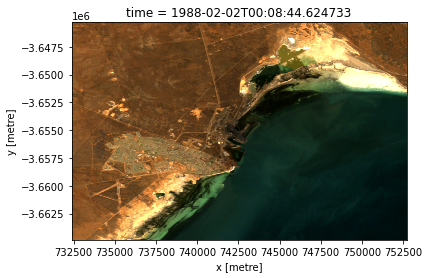

In [22]:
ds.isel(time=0).to_array().plot.imshow(robust=True)

In [30]:
# ds = tidal_tag(ds)
# ds = ds.sel(time = ds.tide_height < 1)
ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:      (time: 307, x: 424, y: 439)
Coordinates:
  * time         (time) datetime64[ns] 1988-02-02T00:08:44.624733 ... 2018-12-05T00:39:14.580767
  * x            (x) float64 7.379e+05 7.379e+05 ... 7.506e+05 7.506e+05
  * y            (y) float64 -3.647e+06 -3.647e+06 ... -3.66e+06 -3.66e+06
Data variables:
    nbart_red    (time, y, x) int16 1215 1156 1144 1141 1137 ... 65 51 50 65 78
    nbart_green  (time, y, x) int16 785 755 761 768 788 ... 211 199 195 206 218
    nbart_blue   (time, y, x) int16 436 417 407 406 420 ... 292 281 278 288 298
Attributes:
    crs:      epsg:32653

In [31]:
# Compute rolling median
ds_rolling = ds.rolling(time=25, center=True, min_periods=1).median()

Generating 307 frame animation
    Exporting animation to animated_timeseries.mp4


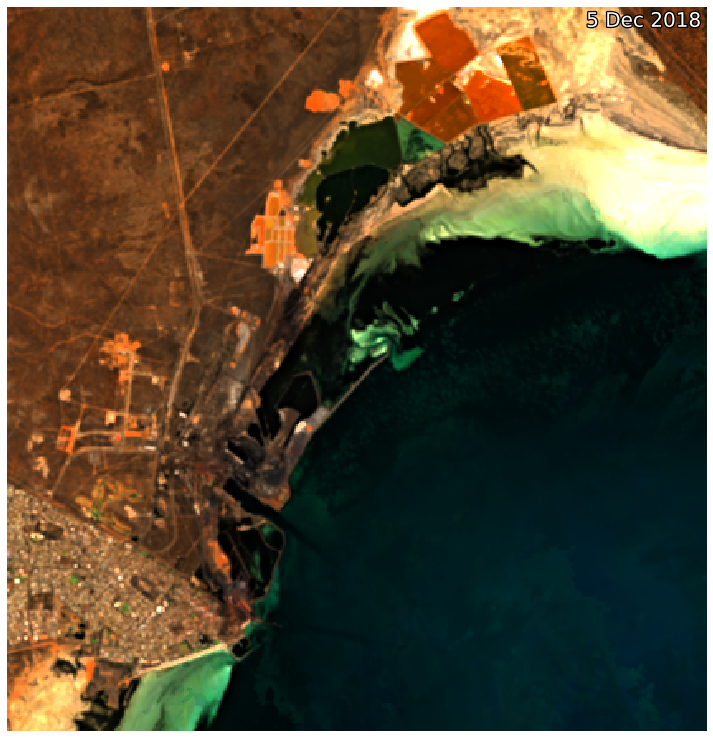

In [32]:
from functools import partial

image_proc_func = partial(hsv_image_processing, val_mult=1.0, sat_mult=1.3, 
                          unsharp_radius1=75, unsharp_amount1=0.6,
                          unsharp_radius2=4, unsharp_amount2=0.8)


# Produce time series animation of red, green and blue bands
animated_timeseries(ds=ds_rolling, 
                    output_path='animated_timeseries.mp4',  
                    bands=['nbart_red', 'nbart_green', 'nbart_blue'],
                    interval=60, 
                    width_pixels=700,
#                     title='Time-series animation',
                    percentile_stretch=[0.00, 0.98],
                    annotation_kwargs={'fontsize': 20},
                    onebandplot_kwargs={'interpolation': 'nearest'},
                    image_proc_func=image_proc_func) 